In [1]:
import numpy as np
from datetime import datetime, timedelta
from pyproj import Proj
import pyproj
import xarray as xr
import matplotlib.pyplot as plt
import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from pyresample import image, geometry
import sys
import metpy
import seaborn as sns
sns.set(style="darkgrid")
import pandas as pd
import statsmodels.api as sm
import os
import os.path as op
DATAPATH= '../../Downloads'
%matplotlib inline

In [2]:
G16 = xr.open_dataset(op.join(DATAPATH,'OR_ABI-L2-CMIPF-M6C07_G16_s20191030000200_e20191030009519_c20191030009583.nc')) #using metpy for reading satellite or weather data
G17 = xr.open_dataset(op.join(DATAPATH,'OR_ABI-L2-CMIPF-M6C07_G17_s20191030000339_e20191030009417_c20191030009458.nc'))

In [3]:
g16_band7 = G16['CMI']
g17_band7 = G17['CMI']


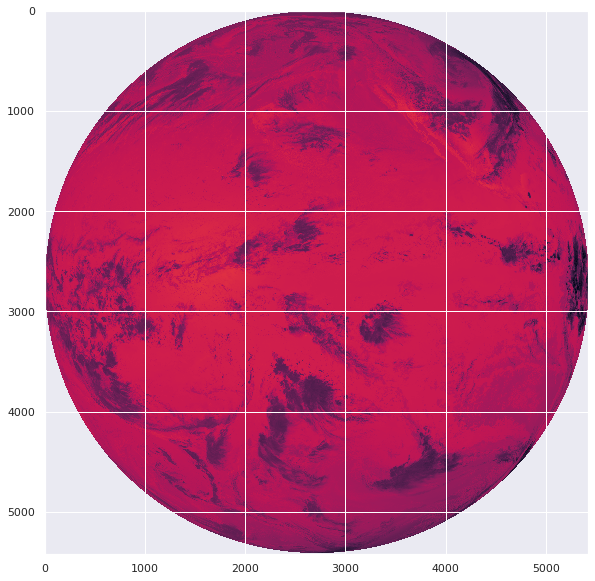

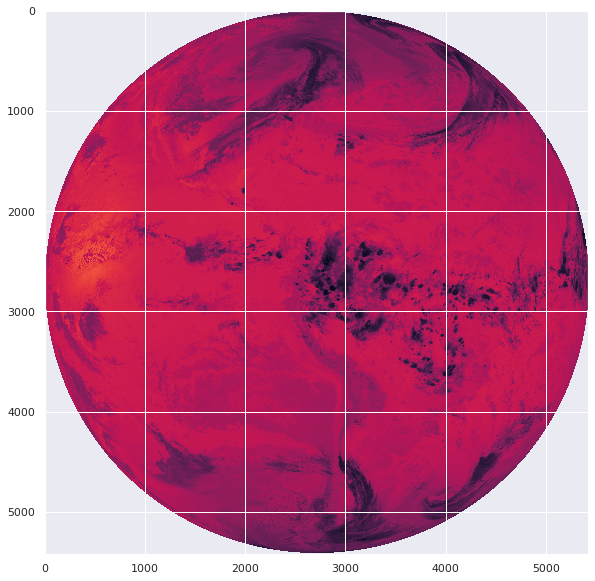

In [4]:
fig_1, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.imshow(g17_band7)
fig_1, ax1 = plt.subplots(1,1, figsize=(10,10))
ax1.imshow(g16_band7)

In [5]:
dat16 = G16.metpy.parse_cf('CMI')
dat17 = G17.metpy.parse_cf('CMI')


/opt/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)
/opt/home/adomakor412/.conda/envs/GOESCode/lib/python3.7/site-packages/pint/quantity.py:1377: UnitStrippedWarning: The unit of the quantity is stripped.
  warnings.warn("The unit of the quantity is stripped.", UnitStrippedWarning)


In [6]:
geos16 = dat16.metpy.cartopy_crs
geos17 = dat17.metpy.cartopy_crs


In [7]:
x16= dat16.x
y16 = dat16.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes16 = (x16.min(), x16.max(), y16.min(), y16.max())
pyresample_extent_goes16 = [float(x16.min()), float(y16.min()), float(x16.max()), float(y16.max())]


x17 = dat17.x
y17 = dat17.y

# Cartopy extents go [x_min, x_max, y_min, y_max]
cartopy_extent_goes17 = (x17.min(), x17.max(), y17.min(), y17.max())
pyresample_extent_goes17 = [float(x17.min()), float(y17.min()), float(x17.max()), float(y17.max())]


Text(0.5, 1.0, 'GOES-17')

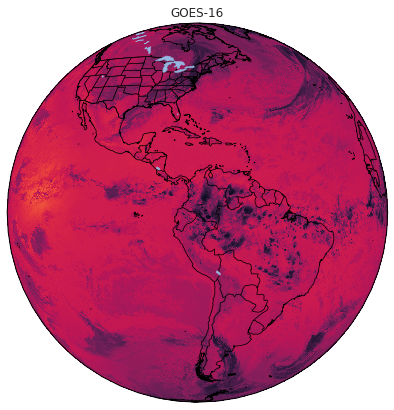

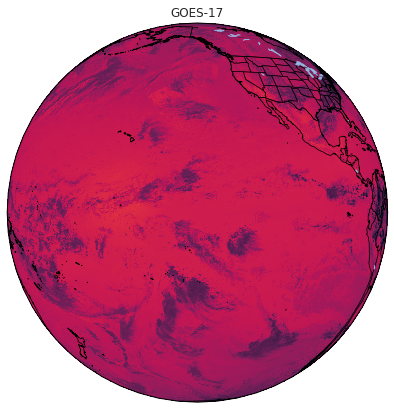

In [8]:
fig_2 = plt.figure(figsize=(15, 8))

ax1_2 = fig_2.add_subplot(1, 2, 1, projection=geos16)


## GOES 16
ax1_2.imshow(g16_band7, origin='upper', extent=cartopy_extent_goes16,
           transform=geos16)
ax1_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax1_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax1_2.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax1_2.set_title('GOES-16')

#-----
fig_2 = plt.figure(figsize=(15, 8))

ax2_2 = fig_2.add_subplot(1, 2, 2, projection=geos17)


## GOES 17
ax2_2.imshow(g17_band7, origin='upper', extent=cartopy_extent_goes17,
           transform=geos17)
ax2_2.coastlines(resolution='50m', color='black', linewidth=.75)
ax2_2.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax2_2.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax2_2.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax2_2.set_title('GOES-17')
#


In [9]:
pc = ccrs.PlateCarree()
mc = ccrs.Mercator()

big_box_extent_pc_cartopy = [-116, -95, -10, 10]
big_box_extent_mc = mc.transform_points(pc, 
                    np.array(big_box_extent_pc_cartopy[:2]),
                    np.array(big_box_extent_pc_cartopy[2:])).ravel()
big_box_extent_mc_cartopy = [
    big_box_extent_mc[0],
    big_box_extent_mc[3],
    big_box_extent_mc[1],
    big_box_extent_mc[4]
]
roi_extent_pc_cartopy = [-109.59326, -102.40674, 
                          8.94659, -8.94656]
roi_extent_mc = mc.transform_points(pc, 
                    np.array(roi_extent_pc_cartopy[:2]),
                    np.array(roi_extent_pc_cartopy[2:])).ravel()
roi_extent_mc_cartopy = [
    roi_extent_mc[0],
    roi_extent_mc[3],
    roi_extent_mc[1],
    roi_extent_mc[4]
]
roi_extent_mc_pyresample = [
    roi_extent_mc[0],
    roi_extent_mc[1],
    roi_extent_mc[3],
    roi_extent_mc[4]
]
print(big_box_extent_mc_cartopy)
print(roi_extent_mc_cartopy)

[-12913060.932019735, -10575351.62536099, -1111475.102852225, 1111475.1028522244]
[-12199865.897574836, -11399866.150599161, 993361.388724224, -993358.0300969948]


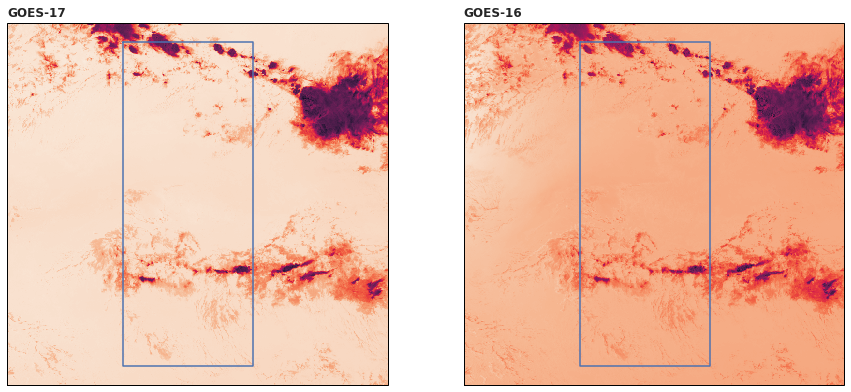

In [11]:

#-----
fig_3 = plt.figure(figsize=(15, 8))

ax_3 = fig_3.add_subplot(1, 2, 1, projection=mc)

ax_3.set_extent(big_box_extent_mc_cartopy, crs=mc)

ax_4 = fig_3.add_subplot(1, 2, 2, projection=mc)

ax_4.set_extent(big_box_extent_mc_cartopy, crs=mc)

roi_x = [roi_extent_mc_cartopy[0], 
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[1],
         roi_extent_mc_cartopy[0],
         roi_extent_mc_cartopy[0]]

roi_y = [roi_extent_mc_cartopy[2], 
         roi_extent_mc_cartopy[2],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[3],
         roi_extent_mc_cartopy[2]]

# GOES16
ax_4.imshow(g16_band7, origin='upper',
           extent=cartopy_extent_goes16,
           transform=geos16,
           interpolation='none')
ax_4.add_feature(ccrs.cartopy.feature.STATES)
ax_4.coastlines(resolution='50m', color='black', linewidth=.75)
ax_4.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax_4.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax_4.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax_4.set_title('GOES-16', loc='left', fontweight='bold')
ax_4.plot(roi_x, roi_y,'b-')

# GOES17
ax_3.imshow(g17_band7, origin='upper',
           extent=cartopy_extent_goes17,
           transform=geos17,
           interpolation='none')
ax_3.add_feature(ccrs.cartopy.feature.STATES)
ax_3.coastlines(resolution='50m', color='black', linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.BORDERS, linewidth=.75)
ax_3.add_feature(ccrs.cartopy.feature.STATES, linewidth=.5)
ax_3.add_feature(ccrs.cartopy.feature.LAKES, linewidth=.5)
ax_3.set_title('GOES-17', loc='left', fontweight='bold')
ax_3.plot(roi_x, roi_y,'b-')


In [12]:
g17_band7_ma = np.ma.masked_array(g17_band7)
g16_band7_ma = np.ma.masked_array(g16_band7)

In [14]:
goes17_params = geos17.proj4_params
goes17_area = geometry.AreaDefinition('GOES-17', 'Full Disk',
                                'GOES-17', goes17_params,
                             g17_band7.shape[1], g17_band7.shape[0],
                              pyresample_extent_goes17)
area_mc_def = geometry.AreaDefinition('areaTest', 'Equator-ROW', 'areaTest',
                                  mc.proj4_params,
                                    500, 200,
                                   roi_extent_mc_pyresample)
geos17_con_nn = image.ImageContainerNearest(g17_band7_ma, 
                                            goes17_area, 
                                            radius_of_influence=50000)

# Here we are using pyresample for the remapping
area_mc_con_nn = geos17_con_nn.resample(area_mc_def)
image_mc_17 = area_mc_con_nn.image_data

#------
goes16_params = geos16.proj4_params
goes16_area = geometry.AreaDefinition('GOES-16', 'Full Disk',
                                'GOES-16', goes17_params,
                             g16_band7.shape[1], g16_band7.shape[0],
                              pyresample_extent_goes16)
area_mc_def = geometry.AreaDefinition('areaTest', 'Equator-ROW', 'areaTest',
                                  mc.proj4_params,
                                    500, 200,
                                   roi_extent_mc_pyresample)
geos16_con_nn = image.ImageContainerNearest(g16_band7_ma, 
                                            goes16_area, 
                                            radius_of_influence=50000)

# Here we are using pyresample for the remapping
area_mc_con_nn = geos16_con_nn.resample(area_mc_def)
image_mc_16 = area_mc_con_nn.image_data

Text(0.0, 1.0, 'GOES-16')

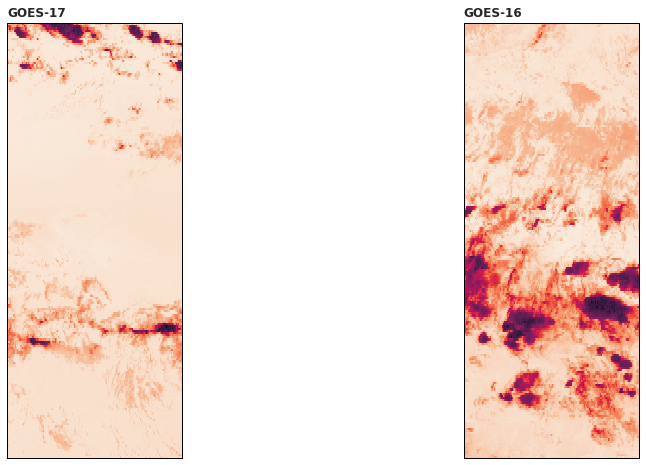

In [16]:
fig_4 = plt.figure(figsize=(15, 8))

ax_5 = fig_4.add_subplot(1, 2, 1, projection=mc)

ax_5.set_extent(roi_extent_mc_cartopy, crs=mc)

ax_6 = fig_4.add_subplot(1, 2, 2, projection=mc)

ax_6.set_extent(roi_extent_mc_cartopy, crs=mc)

# GOES17
ax_5.imshow(image_mc_17, origin='upper',
           extent=roi_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_5.set_title('GOES-17', loc='left', fontweight='bold')

# GOES16
ax_6.imshow(image_mc_16, origin='upper',
           extent=roi_extent_mc_cartopy,
           transform=mc,
           interpolation='none')
ax_6.set_title('GOES-16', loc='left', fontweight='bold')


In [17]:
print('mean_17: ',image_mc_17.mean())
print('std_17: ',image_mc_17.std())

print('mean_16: ',image_mc_16.mean())
print('std_16: ',image_mc_16.std())

mean_17:  295.43573
std_17:  7.81938
mean_16:  283.0422
std_16:  17.924719


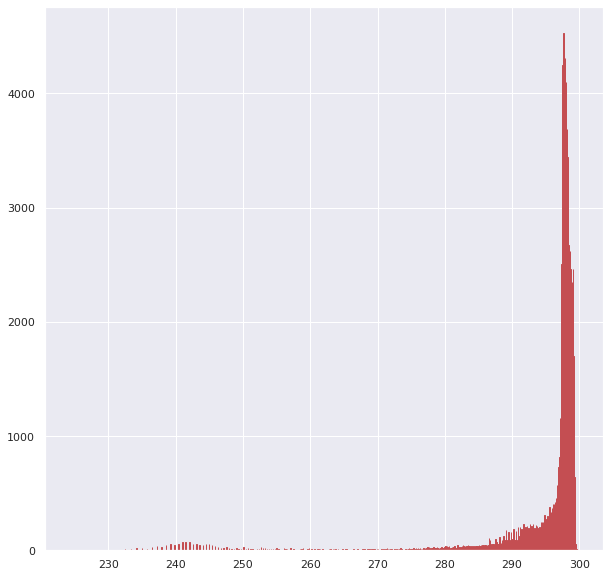

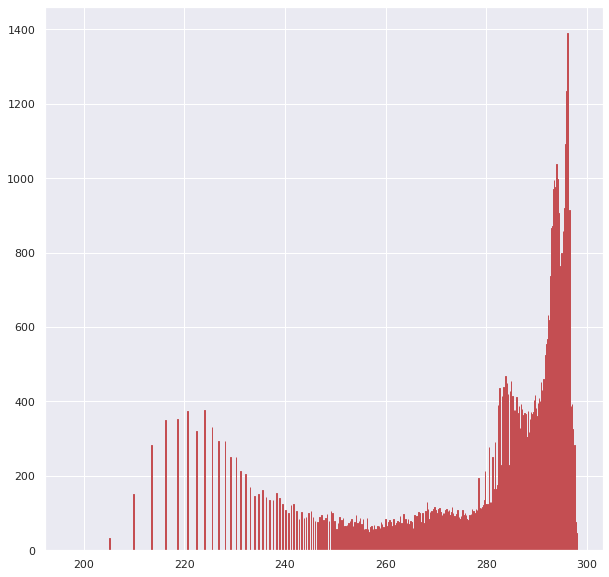

In [23]:
fig_5, ax_7 = plt.subplots(figsize=(10, 10))
values = np.array(image_mc_17).ravel()
counts, bins, _ = ax_7.hist(values,bins=1024,histtype='bar',
           color='r',fc='r',ec='r')
_=ax_5.plot([values.mean(),values.mean()],[0,counts.max()],c='b')

fig_6, ax_8 = plt.subplots(figsize=(10, 10))
values = np.array(image_mc_16).ravel()
counts, bins, _ = ax_8.hist(values,bins=1024,histtype='bar',
           color='r',fc='r',ec='r')
_=ax_5.plot([values.mean(),values.mean()],[0,counts.max()],c='b')

In [28]:
counts_17, bins_17, _ = ax_7.hist(values,bins=1024,histtype='bar',
           color='r',fc='r',ec='r')

counts_16, bins_16, _ = ax_8.hist(values,bins=1024,histtype='bar',
           color='r',fc='r',ec='r')

In [32]:
print('count 17:',counts_17)

print('count 16:',counts_16)

count 17: [ 1.  0.  0. ... 65. 46. 29.]
count 16: [ 1.  0.  0. ... 65. 46. 29.]
